# Gesture Recognition Using LSTM

This notebook loads a sequence-based gesture dataset, preprocesses it, builds a Bidirectional LSTM model using Keras, and evaluates its performance. It also supports detailed exploratory data analysis (EDA) and exports model artifacts.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle


## Parameters

In [2]:
DATA_DIR = "dataset"
SEQUENCE_LENGTH = 30
FEATURE_DIM = 126
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42
BATCH_SIZE = 16
EPOCHS = 50

## Load the dataset

Load `.npy` files from each class folder, ensure sequences are of fixed length by padding or truncating.


In [3]:
labels = []
sequences = []

for gesture in os.listdir(DATA_DIR):
    gesture_dir = os.path.join(DATA_DIR, gesture)
    if not os.path.isdir(gesture_dir):
        continue
    for fname in os.listdir(gesture_dir):
        if not fname.endswith('.npy'):
            continue
        path = os.path.join(gesture_dir, fname)
        seq = np.load(path)
        if seq.shape[0] != SEQUENCE_LENGTH:
            if seq.shape[0] > SEQUENCE_LENGTH:
                seq = seq[:SEQUENCE_LENGTH]
            else:
                pad_width = SEQUENCE_LENGTH - seq.shape[0]
                seq = np.vstack([seq, np.zeros((pad_width, FEATURE_DIM))])
        sequences.append(seq)
        labels.append(gesture)

X = np.array(sequences)
y = np.array(labels)

print(f"Loaded {len(X)} samples from {len(np.unique(y))} classes.")

Loaded 555 samples from 4 classes.


# Exploratory Data analysis
## Class distribution


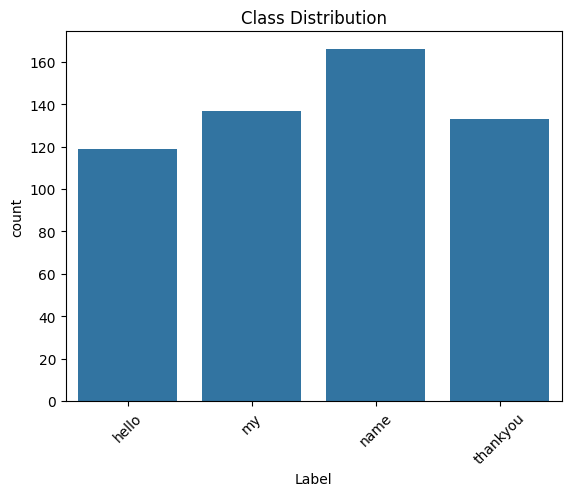

In [4]:
df = pd.DataFrame({'Label': y})
sns.countplot(data=df, x='Label')
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

# Encode labels

In [5]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)


# Split Dataset

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_cat, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_cat)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VAL_SIZE/(1 - TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=y_train_val
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 387, Val: 84, Test: 84


# Build model

In [7]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQUENCE_LENGTH, FEATURE_DIM)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\User\Desktop\HandSign_detection\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        97,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,124 (801.27 KB)

 Trainable params: 205,124 (801.27 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [8]:
checkpoint_path = 'artifacts/best_gesture_model.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3448 - loss: 1.2708

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.3535 - loss: 1.2569 - val_accuracy: 0.7500 - val_loss: 0.6397
Epoch 2/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6904 - loss: 0.7024

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6925 - loss: 0.6973 - val_accuracy: 0.9643 - val_loss: 0.3243
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8689 - loss: 0.3863

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8690 - loss: 0.3865 - val_accuracy: 0.8810 - val_loss: 0.2440
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8246 - loss: 0.4389

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8261 - loss: 0.4370 - val_accuracy: 0.9643 - val_loss: 0.0746
Epoch 5/50
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9369 - loss: 0.2677

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9335 - loss: 0.2728 - val_accuracy: 1.0000 - val_loss: 0.0499
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9423 - loss: 0.1836 - val_accuracy: 0.9643 - val_loss: 0.0955
Epoch 7/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9492 - loss: 0.1461

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9503 - loss: 0.1453 - val_accuracy: 1.0000 - val_loss: 0.0184
Epoch 8/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9805 - loss: 0.0876

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9807 - loss: 0.0870 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9898 - loss: 0.0733 - val_accuracy: 0.8810 - val_loss: 0.3471
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8964 - loss: 0.2641 - val_accuracy: 1.0000 - val_loss: 0.0123
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9462 - loss: 0.1882 - val_accuracy: 1.0000 - val_loss: 0.0160
Epoch 12/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9892 - loss: 0.0837

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9884 - loss: 0.0858 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9858 - loss: 0.0533 - val_accuracy: 0.9881 - val_loss: 0.0198
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9810 - loss: 0.0760 - val_accuracy: 0.9762 - val_loss: 0.0912
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9771 - loss: 0.1221 - val_accuracy: 0.9762 - val_loss: 0.0692
Epoch 16/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9719 - loss: 0.1024 - val_accuracy: 0.9881 - val_loss: 0.0758
Epoch 17/50
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9954 - loss: 0.0303

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9953 - loss: 0.0302 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 18/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9907 - loss: 0.0273 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 19/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9951 - loss: 0.0254

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9950 - loss: 0.0256 - val_accuracy: 1.0000 - val_loss: 6.8819e-04
Epoch 20/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9884 - loss: 0.0350

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9886 - loss: 0.0348 - val_accuracy: 1.0000 - val_loss: 5.3648e-04
Epoch 21/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9814 - loss: 0.0902 - val_accuracy: 0.9643 - val_loss: 0.1897
Epoch 22/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9831 - loss: 0.1017 - val_accuracy: 0.9881 - val_loss: 0.0863
Epoch 23/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9906 - loss: 0.0305 - val_accuracy: 0.9881 - val_loss: 0.0715
Epoch 24/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9942 - loss: 0.0249

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9943 - loss: 0.0246 - val_accuracy: 1.0000 - val_loss: 1.9875e-04
Epoch 25/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9950 - loss: 0.0126

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9949 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 1.5572e-04
Epoch 26/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9998 - loss: 0.0096

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9997 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 1.2899e-04
Epoch 27/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9835 - loss: 0.0350

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9835 - loss: 0.0350 - val_accuracy: 1.0000 - val_loss: 8.7341e-05
Epoch 28/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9931 - loss: 0.0222 - val_accuracy: 1.0000 - val_loss: 1.3538e-04
Epoch 29/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9916 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 2.0495e-04
Epoch 30/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9995 - loss: 0.0053 - val_accuracy: 0.9881 - val_loss: 0.1109
Epoch 31/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9941 - loss: 0.0167 - val_accuracy: 0.9643 - val_loss: 0.2131
Epoch 32/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9565 - loss: 0.1313 - val_accuracy: 0.9762 - val_loss: 0.1364
Epoch 33/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9769 - loss: 0.0526 - val_accuracy: 0.9643 - val_loss: 0.2341
Epoch 34/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9314 - loss: 0.3679 - val_accuracy: 0.

# Plot training history

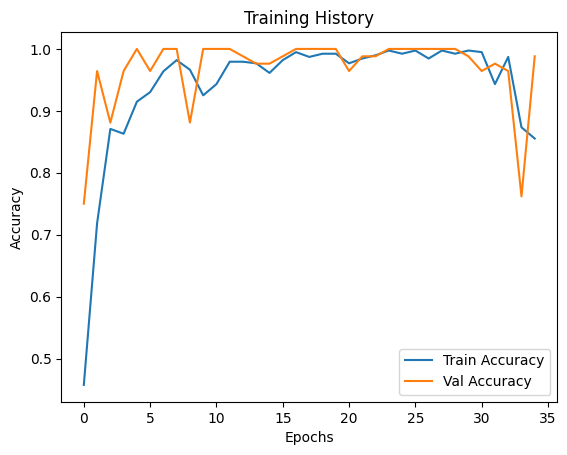

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training History")
plt.show()


# Evaluate and Analyze Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9823 - loss: 0.0568
Test Accuracy: 0.9881
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step

Classification Report:
              precision    recall  f1-score   support

       hello       1.00      1.00      1.00        18
          my       1.00      0.95      0.98        21
        name       0.96      1.00      0.98        25
    thankyou       1.00      1.00      1.00        20

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84



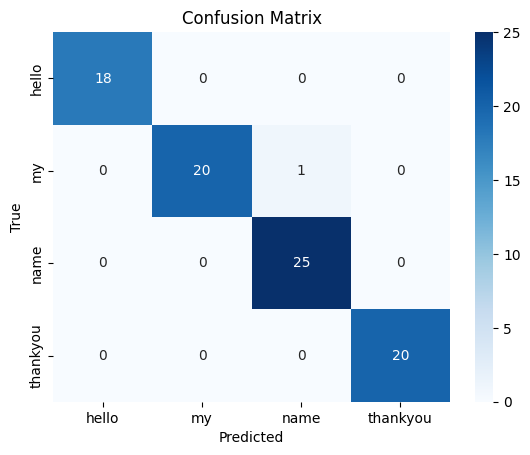

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
y_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Save Artifacts

In [11]:
with open('artifacts/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and label encoder saved.")


Model and label encoder saved.
